In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from helper import get_performance, get_conflict_commit_performance, get_merge_coflict_mispredicted_region_test
from sklearn.metrics import classification_report
EPOCHS = 700
BATCH_SIZE = 2048
ACTIVATION = 'swish'
LEARNING_RATE = 0.0007
FOLDS = 5

In [36]:
DATA_PATH = "/data/conflict-prediction-master/replication_package/prediction_data/data_Java.csv"
LABEL_PATH = "/data//conflict-prediction-master/replication_package/prediction_data/label_Java.csv"


X = pd.read_csv(DATA_PATH)
y = pd.read_csv(LABEL_PATH)
print(X.shape)
print(y.shape)
print('------')
print(y.value_counts())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


(26699, 28)
(26699, 1)
------
is_conflict
0              24519
1               2180
dtype: int64


In [44]:
y_train_ravel = y_train.values.ravel()

# Default Model

In [45]:
model_default = RandomForestClassifier()
scores_default = cross_val_score(model_default, X=X_train, y=y_train_ravel, cv = FOLDS)
model_default.fit(X_train, y_train)
y_pred_default = model_default.predict(X_test)

print(classification_report(y_test, y_pred_default))

<ipython-input-45-697178f4761c>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_default.fit(X_train, y_train)


              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7348
           1       0.75      0.57      0.65       662

    accuracy                           0.95      8010
   macro avg       0.86      0.78      0.81      8010
weighted avg       0.94      0.95      0.95      8010



# SMOTE Oversampling

In [13]:
# SMOTE Oversampling
    # Transform data 
oversample = SMOTE()
X_train_sm, y_train_sm = oversample.fit_resample(X_train, y_train)
model_SMOTE = RandomForestClassifier()
scores_SMOTE = cross_val_score(model_SMOTE, X=X_train_sm, y=y_train_sm, cv = FOLDS)
model_SMOTE.fit(X_train_sm, y_train_sm)
y_pred_SMOTE = model_SMOTE.predict(X_test)

print(classification_report(y_test, y_pred_SMOTE))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      7348
           1       0.64      0.73      0.68       662

    accuracy                           0.94      8010
   macro avg       0.81      0.85      0.83      8010
weighted avg       0.95      0.94      0.95      8010



## MAPS

In [14]:
import time 
import sys
sys.path.insert(1, './mmd')
from mmd import diagnoser
from scipy import stats as st
import numpy
#notebook's library
%matplotlib inline
from helper import get_top_f1_rules, get_relevent_attributs_target, get_MMD_results, get_biased_features, get_BGMD_results
from helper import generateTrain_data_Weights

In [15]:
def mispredict_label(row):
    if row['is_conflict'] == row['pred']:
        return False
    return True
#use first default model result to detect mispredictions
default_result = pd.concat([X_test, y_test], axis=1, join='inner')
default_result.loc[:,"pred"] = y_pred_default

# default_result = default_result.loc[default_result["is_conflict"] == 1]
default_result_copy = default_result.copy()
X_test_copy = default_result.copy().drop(['is_conflict', 'pred'], axis=1)
X_test_copy['mispredict'] = default_result_copy.apply(lambda row: mispredict_label(row), axis=1)


In [16]:
settings = diagnoser.Settings
settings.all_rules = False

# Get relevent attributes and target 
relevant_attributes, Target = get_relevent_attributs_target(X_test_copy)
# Geerate MMD rules and correspodning information
MMD_rules, MMD_time, MMD_Features = get_MMD_results(X_test_copy, relevant_attributes, Target, settings)

#Get biased attributes this time 
biased_attributes = get_biased_features(X_test_copy, relevant_attributes)

BGMD_rules, BGMD_time, BGMD_Features = get_BGMD_results(X_test_copy, biased_attributes, Target, settings)


print('MMD Spent:', MMD_time, 'BGMD Spent:', BGMD_time)
MMD_rules, BGMD_rules

Original Rule
Subgroup Discovery Result

Found 3 subgroups
Dataset
Target: mispredict=True
# Rows:	8010
# Cols:	29
% Target in dataset 4.99%
Subgroup: improve_frequency>3.0
% of subgroup in population (Full Dataset):	0.15% (12 rows)
Precision: P(mispredict=True | improve_frequency>3.0) = 25.0%
Recall: P(improve_frequency>3.0 | mispredict=True) = 0.75%
Subgroup: developer_num<=-65.0
% of subgroup in population (Full Dataset):	0.56% (45 rows)
Precision: P(mispredict=True | developer_num<=-65.0) = 22.22%
Recall: P(developer_num<=-65.0 | mispredict=True) = 2.5%
Subgroup: developer_num>14.0
% of subgroup in population (Full Dataset):	0.9% (72 rows)
Precision: P(mispredict=True | developer_num>14.0) = 20.83%
Recall: P(developer_num>14.0 | mispredict=True) = 3.75%
time: 18.88377332687378
Feature Number 29

###############################

BGMD Rule
Subgroup Discovery Result

Found 3 subgroups
Dataset
Target: mispredict=True
# Rows:	8010
# Cols:	29
% Target in dataset 4.99%
Subgroup: developer

([[0.0635593220338983, 'developer_num>14.0'],
  [0.04494382022471911, 'developer_num<=-65.0'],
  [0.014563106796116504, 'improve_frequency>3.0']],
 [[0.14050822122571, 'file_modified<=-5110.0'],
  [0.0635593220338983, 'developer_num>14.0'],
  [0.04494382022471911, 'developer_num<=-65.0']])

In [17]:
from helper import get_test_data_in_misprediction_areas

final_result = pd.concat([X_test, y_test], axis=1, join='inner')

indexes_in_misprediction_area = get_test_data_in_misprediction_areas(BGMD_rules, X_test)
y_actual_MD = []

for index in indexes_in_misprediction_area:
        y_actual_MD.append(final_result.loc[index]['is_conflict'])


In [18]:
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support
grid_upweights = range(1, 21)
best_weight_all = 1
best_f1_all = 0
best_weight_mis = 1
best_f1_mis = 0
f1_all = []
f1_mispredicted = []
acc_all = []
acc_mispredicted = []
recall_all = []
recall_mispredicted = []
for upweight in grid_upweights:
    # give extra weights to training samples in mispredited areas 
    print('Upweight_value: ', upweight)
    weights = generateTrain_data_Weights(BGMD_rules, X_train, upweight_value=upweight)

    c = Counter(weights)
#     print(c.items())

    MAPS_model = RandomForestClassifier()
    scores_MAPS = cross_val_score(MAPS_model, X=X_train, y=y_train, cv = FOLDS)
    MAPS_model.fit(X_train, y_train, sample_weight = weights)

    y_pred_MAPS = MAPS_model.predict(X_test)

    total_result = get_conflict_commit_performance(X_test, y_test, y_pred_MAPS)
    
    acc_all.append(total_result[0][0])
    recall_all.append(total_result[1][0])
    f1_all.append(total_result[2][0])
    
    final_result['y_pred_MAPS'] = y_pred_MAPS
    y_pred_MAPS_MD = []
    for index in indexes_in_misprediction_area:
        y_pred_MAPS_MD.append(final_result.loc[index]['y_pred_MAPS'])
        
    MAPS_MD_metric = precision_recall_fscore_support(y_actual_MD, y_pred_MAPS_MD, labels=[1])
    
    acc_mispredicted.append(MAPS_MD_metric[0][0])
    recall_mispredicted.append(MAPS_MD_metric[1][0])
    f1_mispredicted.append(MAPS_MD_metric[2][0])
    
    if total_result[2][0] > best_f1_all:
        best_f1_all = total_result[2][0]
        best_weight_all = upweight;
    if MAPS_MD_metric[2][0] > best_f1_mis:
        best_f1_mis = MAPS_MD_metric[2][0]
        best_weight_mis = upweight

Upweight_value:  1
Upweight_value:  2
Upweight_value:  3
Upweight_value:  4
Upweight_value:  5
Upweight_value:  6
Upweight_value:  7
Upweight_value:  8
Upweight_value:  9
Upweight_value:  10
Upweight_value:  11
Upweight_value:  12
Upweight_value:  13
Upweight_value:  14
Upweight_value:  15
Upweight_value:  16
Upweight_value:  17
Upweight_value:  18
Upweight_value:  19
Upweight_value:  20


Best weight on all is:  12
Best weight on misprediction area is:  6


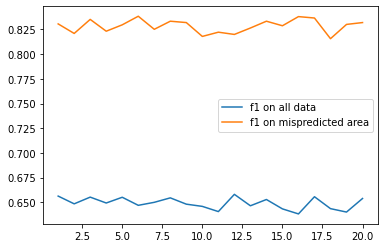

In [19]:
print("Best weight on all is: ", best_weight_all)
print("Best weight on misprediction area is: ", best_weight_mis)
plt.plot(grid_upweights, f1_all, label = "f1 on all data")
plt.plot(grid_upweights, f1_mispredicted, label = "f1 on mispredicted area")
plt.legend()
plt.show()
dict = {'acc_all': acc_all, 'recall_all': recall_all, 'f1_all': f1_all, 'acc_mispredicted': acc_mispredicted, 'recall_mispredicted': recall_mispredicted, 'f1_mispredicted': f1_mispredicted}
out = pd.DataFrame(dict)
out.to_csv('Merge_Conflict_Java_DT.csv')

In [20]:
# MAPS all
acc_all[best_weight_all-1], recall_all[best_weight_all-1], f1_all[best_weight_all-1]

(0.7629482071713147, 0.5785498489425982, 0.6580756013745704)

In [21]:
# MAPS mispredict area
acc_mispredicted[best_weight_mis-1], recall_mispredicted[best_weight_mis-1], f1_mispredicted[best_weight_mis-1]

(0.8225806451612904, 0.8547486033519553, 0.8383561643835615)

In [22]:
get_merge_coflict_mispredicted_region_test(X_test, y_test, y_pred_default, y_pred_SMOTE, y_pred_MAPS, BGMD_rules, ylabel='is_conflict')

Default: (array([0.82681564]), array([0.82681564]), array([0.82681564]), array([179]))
SMOTE: (array([0.78365385]), array([0.91061453]), array([0.84237726]), array([179]))


# JTT

In [23]:
from helper import generate_JTT_Weights

In [37]:
X_train_1st, X_val, y_train_1st, y_val = train_test_split(X_train, y_train, test_size = 0.33, random_state = 29)

model_JTT = RandomForestClassifier()
scores_JTT_1st = cross_val_score(model_JTT, X_train_1st, y=y_train_1st, cv = FOLDS)
model_JTT.fit(X_train_1st, y_train_1st)
y_pred_JTT_val = model_JTT.predict(X_val)

/Users/jirigesi/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jirigesi/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jirigesi/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jirigesi/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680:

In [38]:
y_val

,is_conflict
22963,0
8016,0
14560,0
4625,0
22400,0
...,...
16870,0
25785,0
23641,0
9146,0


In [39]:
grid_upweights_JTT = [10, 20, 30, 40, 50]
best_weight_all_JTT = 1
best_f1_all_JTT = 0
best_weight_mis_JTT = 1
best_f1_mis_JTT = 0
f1_all_JTT = []
f1_mispredicted_JTT = []
precision_all_JTT = []
precision_mispredicted_JTT = []
recall_all_JTT = []
recall_mispredicted_JTT = []

for i, upweight in enumerate(grid_upweights_JTT):
    weights = generate_JTT_Weights(y_val['is_conflict'].to_list(), y_pred_JTT_val, weight = upweight)
    
    #combine train and validate data
    weights = np.concatenate((np.ones(len(X_train_1st)), weights))
    y_train_2nd = np.concatenate((y_train_1st, y_val))
    X_train_2nd = pd.concat([X_train_1st, X_val])
    X_train_2nd['val_weight'] = weights
    X_train_2nd['target'] = y_train_2nd
    X_train_2nd = X_train_2nd.sample(frac=1, random_state=1).reset_index(drop=True)
    weights = X_train_2nd['val_weight'].to_list()
    y_train_2nd = X_train_2nd['target']
    X_train_2nd = X_train_2nd.drop(['val_weight', 'target'], axis=1)
    
    model_JTT = RandomForestClassifier()
    scores_JTT_2nd = cross_val_score(model_JTT, X_train_2nd, y=y_train_2nd, cv = FOLDS)
    model_JTT.fit(X_train_2nd, y_train_2nd, sample_weight = weights)
    y_pred_JTT = model_JTT.predict(X_test)
    
    total_result_JTT = get_conflict_commit_performance(X_test, y_test, y_pred_JTT)
    
    precision_all_JTT.append(total_result_JTT[0][0])
    recall_all_JTT.append(total_result_JTT[1][0])
    f1_all_JTT.append(total_result_JTT[2][0])
    
    final_result['y_pred_JTT'] = y_pred_JTT
    y_pred_JTT_MD = []
    for index in indexes_in_misprediction_area:
        y_pred_JTT_MD.append(final_result.loc[index]['y_pred_JTT'])
        
    JTT_MD_metric = precision_recall_fscore_support(y_actual_MD, y_pred_JTT_MD, labels=[1])
    
    precision_mispredicted_JTT.append(JTT_MD_metric[0][0])
    recall_mispredicted_JTT.append(JTT_MD_metric[1][0])
    f1_mispredicted_JTT.append(JTT_MD_metric[2][0])
    
    if total_result_JTT[2][0] > best_f1_all_JTT:
        best_f1_all = total_result_JTT[2][0]
        best_weight_all = i;
    if JTT_MD_metric[2][0] > best_f1_mis_JTT:
        best_f1_mis = JTT_MD_metric[2][0]
        best_weight_mis = i

In [40]:
print("JTT Best weight on all is: ", grid_upweights_JTT[best_weight_all])
print("JTT Best weight on mispredicted area is: ", grid_upweights_JTT[best_weight_mis])

JTT Best weight on all is:  50
JTT Best weight on mispredicted area is:  50


In [41]:
# JTT all
precision_all_JTT[best_weight_all_JTT-1], recall_all_JTT[best_weight_all_JTT-1], f1_all_JTT[best_weight_all_JTT-1]

(0.7535641547861507, 0.5589123867069486, 0.6418039895923676)

In [42]:
# JTT mispredict area
precision_mispredicted_JTT[best_weight_mis_JTT-1], recall_mispredicted_JTT[best_weight_mis_JTT-1], f1_mispredicted_JTT[best_weight_mis_JTT-1]

(0.8152173913043478, 0.8379888268156425, 0.8264462809917356)